![Henry Logo](https://www.soyhenry.com/_next/static/media/HenryLogo.bb57fd6f.svg)

# Bases de Datos Vectoriales - Fundamentos

## Objetivos de aprendizaje

Al finalizar esta notebook seras capaz de:

1. Comprender que es un vector y como se usa para representar texto
2. Generar embeddings con OpenAI y modelos open-source (HuggingFace)
3. Calcular similitud coseno y distancia euclidiana desde cero
4. Crear tu primera base de datos vectorial con ChromaDB
5. Realizar busquedas semanticas con y sin filtros de metadata
6. Visualizar embeddings en 2D con PCA y t-SNE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from dotenv import find_dotenv, load_dotenv
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import chromadb
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
import time
import warnings
warnings.filterwarnings('ignore')

load_dotenv(find_dotenv())

print("Todas las dependencias cargadas correctamente.")

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Todas las dependencias cargadas correctamente.


---
## Seccion 1: Que es un Vector?

Un **vector** es una lista ordenada de numeros que representa una direccion y magnitud en un espacio. En machine learning, los vectores son la forma fundamental de representar datos.

Empecemos con lo mas basico: vectores en 2D y 3D.

### 1.1 Vectores en 2D

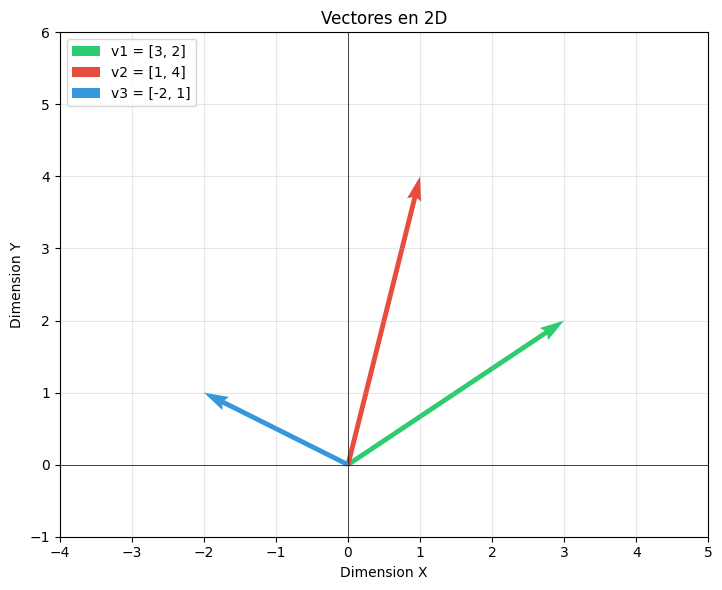

In [2]:
# Definir vectores 2D
v1 = np.array([3, 2])
v2 = np.array([1, 4])
v3 = np.array([-2, 1])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

origin = np.array([0, 0])
vectors = [v1, v2, v3]
colors = ['#2ecc71', '#e74c3c', '#3498db']
labels = ['v1 = [3, 2]', 'v2 = [1, 4]', 'v3 = [-2, 1]']

for v, c, l in zip(vectors, colors, labels):
    ax.quiver(*origin, *v, angles='xy', scale_units='xy', scale=1,
              color=c, linewidth=2.5, label=l)

ax.set_xlim(-4, 5)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Dimension X')
ax.set_ylabel('Dimension Y')
ax.set_title('Vectores en 2D')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [3]:
# Magnitud de un vector: |v| = sqrt(x^2 + y^2)
for v, l in zip(vectors, labels):
    mag = np.linalg.norm(v)
    print(f"{l}  ->  magnitud = {mag:.4f}")

print("\nLa magnitud indica 'cuanto' hay de algo, la direccion indica 'que tipo'.")

v1 = [3, 2]  ->  magnitud = 3.6056
v2 = [1, 4]  ->  magnitud = 4.1231
v3 = [-2, 1]  ->  magnitud = 2.2361

La magnitud indica 'cuanto' hay de algo, la direccion indica 'que tipo'.


### 1.2 Vectores en 3D

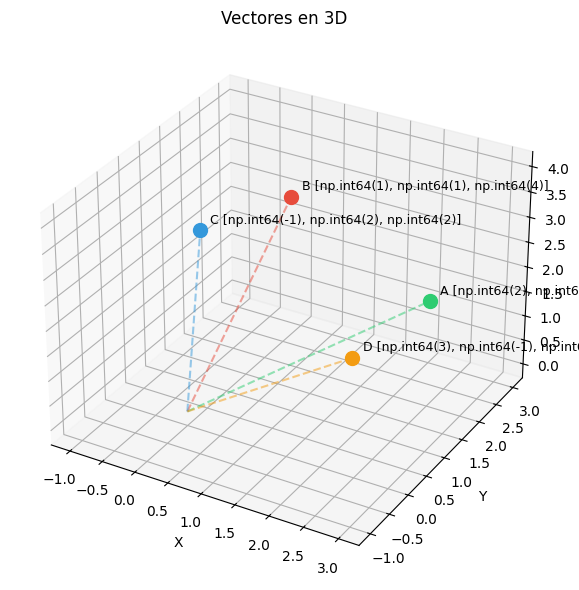

In [4]:
# Vectores 3D
points_3d = np.array([
    [2, 3, 1],
    [1, 1, 4],
    [-1, 2, 2],
    [3, -1, 3],
])
labels_3d = ['A', 'B', 'C', 'D']
colors_3d = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for p, c, l in zip(points_3d, colors_3d, labels_3d):
    ax.scatter(*p, color=c, s=100, depthshade=True)
    ax.text(p[0]+0.1, p[1]+0.1, p[2]+0.1, f"{l} {list(p)}", fontsize=9)
    ax.plot([0, p[0]], [0, p[1]], [0, p[2]], color=c, alpha=0.5, linestyle='--')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Vectores en 3D')

plt.tight_layout()
plt.show()

> **Idea clave:** Los embeddings de texto son vectores iguales a estos, pero con 384 o 1536 dimensiones en vez de 2 o 3. No podemos visualizarlos directamente, pero las operaciones matematicas son las mismas.

---
## Seccion 2: Que es un Embedding?

Un **embedding** es un vector que representa el significado semantico de un texto. Textos con significados similares tendran vectores cercanos en el espacio.

Vamos a generar embeddings con dos modelos diferentes:
- **OpenAI `text-embedding-3-small`**: 1536 dimensiones, API de pago
- **HuggingFace `all-MiniLM-L6-v2`**: 384 dimensiones, gratuito y local

> **Nota:** La primera ejecucion de SentenceTransformer descargara el modelo (~80MB).

### 2.1 Embeddings con OpenAI

In [5]:
client = OpenAI()

textos = [
    "El gato duerme en el sofa",
    "El felino descansa en el sillon",
    "Python es un lenguaje de programacion",
]

response = client.embeddings.create(
    input=textos,
    model="text-embedding-3-small"
)

embeddings_openai = np.array([e.embedding for e in response.data])

print(f"Forma del array: {embeddings_openai.shape}")
print(f"Dimensiones por embedding: {embeddings_openai.shape[1]}")
print(f"\nPrimeros 10 valores del primer embedding:")
print(embeddings_openai[0][:10])

Forma del array: (3, 1536)
Dimensiones por embedding: 1536

Primeros 10 valores del primer embedding:
[-0.05751448 -0.03040856 -0.03757774  0.03691318  0.02134641 -0.00332782
  0.00096034  0.06061575  0.00049842 -0.05755476]


### 2.2 Embeddings con HuggingFace (local)

In [6]:
model_hf = SentenceTransformer('all-MiniLM-L6-v2')

embeddings_hf = model_hf.encode(textos)

print(f"Forma del array: {embeddings_hf.shape}")
print(f"Dimensiones por embedding: {embeddings_hf.shape[1]}")
print(f"\nPrimeros 10 valores del primer embedding:")
print(embeddings_hf[0][:10])

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|          | 1/103 [00:00<00:00, 19239.93it/s, Materializing param=embeddings.LayerNorm.bias]

Loading weights:   1%|          | 1/103 [00:00<00:00, 915.59it/s, Materializing param=embeddings.LayerNorm.bias]  

Loading weights:   2%|▏         | 2/103 [00:00<00:00, 633.92it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   2%|▏         | 2/103 [00:00<00:00, 454.13it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   3%|▎         | 3/103 [00:00<00:00, 562.84it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   3%|▎         | 3/103 [00:00<00:00, 522.29it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   4%|▍         | 4/103 [00:00<00:00, 621.31it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   4%|▍         | 4/103 [00:00<00:00, 519.40it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   5%|▍         | 5/103 [00:00<00:00, 610.42it/s, Materializing param=embeddings.word_embeddings.weight]      

Loading weights:   5%|▍         | 5/103 [00:00<00:00, 600.30it/s, Materializing param=embeddings.word_embeddings.weight]

Loading weights:   6%|▌         | 6/103 [00:00<00:00, 707.72it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|▌         | 6/103 [00:00<00:00, 698.64it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|▋         | 7/103 [00:00<00:00, 799.26it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|▋         | 7/103 [00:00<00:00, 790.42it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|▊         | 8/103 [00:00<00:00, 889.87it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]      

Loading weights:   8%|▊         | 8/103 [00:00<00:00, 880.28it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|▊         | 9/103 [00:00<00:00, 977.62it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|▊         | 9/103 [00:00<00:00, 967.32it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|▉         | 10/103 [00:00<00:00, 1061.20it/s, Materializing param=encoder.layer.0.attention.self.key.bias]    

Loading weights:  10%|▉         | 10/103 [00:00<00:00, 1051.18it/s, Materializing param=encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|█         | 11/103 [00:00<00:00, 1136.81it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|█         | 11/103 [00:00<00:00, 1127.39it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█▏        | 12/103 [00:00<00:00, 1211.15it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█▏        | 12/103 [00:00<00:00, 1198.69it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|█▎        | 13/103 [00:00<00:00, 1283.33it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|█▎        | 13/103 [00:00<00:00, 1270.76it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|█▎        | 14/103 [00:00<00:00, 1352.50it/s, Materializing param=encoder.layer.0.attention.self.value.bias]  

Loading weights:  14%|█▎        | 14/103 [00:00<00:00, 1334.58it/s, Materializing param=encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|█▍        | 15/103 [00:00<00:00, 1406.07it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|█▍        | 15/103 [00:00<00:00, 1390.41it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|█▌        | 16/103 [00:00<00:00, 1448.37it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]    

Loading weights:  16%|█▌        | 16/103 [00:00<00:00, 1430.98it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█▋        | 17/103 [00:00<00:00, 1500.71it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█▋        | 17/103 [00:00<00:00, 1481.87it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█▋        | 18/103 [00:00<00:00, 1548.51it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]    

Loading weights:  17%|█▋        | 18/103 [00:00<00:00, 1532.17it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|█▊        | 19/103 [00:00<00:00, 1597.29it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|█▊        | 19/103 [00:00<00:00, 1582.00it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|█▉        | 20/103 [00:00<00:00, 1645.02it/s, Materializing param=encoder.layer.0.output.dense.bias]      

Loading weights:  19%|█▉        | 20/103 [00:00<00:00, 1630.79it/s, Materializing param=encoder.layer.0.output.dense.bias]

Loading weights:  20%|██        | 21/103 [00:00<00:00, 1693.56it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:  20%|██        | 21/103 [00:00<00:00, 1672.21it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:  21%|██▏       | 22/103 [00:00<00:00, 1713.26it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|██▏       | 22/103 [00:00<00:00, 1694.92it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██▏       | 23/103 [00:00<00:00, 1753.73it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██▏       | 23/103 [00:00<00:00, 1740.03it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██▎       | 24/103 [00:00<00:00, 1797.88it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]      

Loading weights:  23%|██▎       | 24/103 [00:00<00:00, 1782.91it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|██▍       | 25/103 [00:00<00:00, 1841.35it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|██▍       | 25/103 [00:00<00:00, 1828.00it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|██▌       | 26/103 [00:00<00:00, 1880.21it/s, Materializing param=encoder.layer.1.attention.self.key.bias]      

Loading weights:  25%|██▌       | 26/103 [00:00<00:00, 1861.14it/s, Materializing param=encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██▌       | 27/103 [00:00<00:00, 1910.26it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██▌       | 27/103 [00:00<00:00, 1893.27it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|██▋       | 28/103 [00:00<00:00, 1943.64it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|██▋       | 28/103 [00:00<00:00, 1930.76it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██▊       | 29/103 [00:00<00:00, 1986.43it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██▊       | 29/103 [00:00<00:00, 1972.13it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|██▉       | 30/103 [00:00<00:00, 2021.16it/s, Materializing param=encoder.layer.1.attention.self.value.bias]  

Loading weights:  29%|██▉       | 30/103 [00:00<00:00, 2007.48it/s, Materializing param=encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███       | 31/103 [00:00<00:00, 2053.37it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███       | 31/103 [00:00<00:00, 2038.69it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|███       | 32/103 [00:00<00:00, 2087.53it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]    

Loading weights:  31%|███       | 32/103 [00:00<00:00, 2074.40it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|███▏      | 33/103 [00:00<00:00, 2123.83it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|███▏      | 33/103 [00:00<00:00, 2109.43it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|███▎      | 34/103 [00:00<00:00, 2147.30it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]    

Loading weights:  33%|███▎      | 34/103 [00:00<00:00, 2134.44it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|███▍      | 35/103 [00:00<00:00, 2180.83it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|███▍      | 35/103 [00:00<00:00, 2168.11it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|███▍      | 36/103 [00:00<00:00, 2212.93it/s, Materializing param=encoder.layer.1.output.dense.bias]      

Loading weights:  35%|███▍      | 36/103 [00:00<00:00, 2196.61it/s, Materializing param=encoder.layer.1.output.dense.bias]

Loading weights:  36%|███▌      | 37/103 [00:00<00:00, 2234.32it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:  36%|███▌      | 37/103 [00:00<00:00, 2217.02it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:  37%|███▋      | 38/103 [00:00<00:00, 2247.72it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|███▋      | 38/103 [00:00<00:00, 2230.54it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|███▊      | 39/103 [00:00<00:00, 2267.82it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|███▊      | 39/103 [00:00<00:00, 2253.91it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|███▉      | 40/103 [00:00<00:00, 2292.25it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]      

Loading weights:  39%|███▉      | 40/103 [00:00<00:00, 2278.27it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|███▉      | 41/103 [00:00<00:00, 2317.70it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|███▉      | 41/103 [00:00<00:00, 2302.83it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|████      | 42/103 [00:00<00:00, 2338.92it/s, Materializing param=encoder.layer.2.attention.self.key.bias]      

Loading weights:  41%|████      | 42/103 [00:00<00:00, 2323.65it/s, Materializing param=encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|████▏     | 43/103 [00:00<00:00, 2362.74it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|████▏     | 43/103 [00:00<00:00, 2350.21it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|████▎     | 44/103 [00:00<00:00, 2388.96it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|████▎     | 44/103 [00:00<00:00, 2375.15it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|████▎     | 45/103 [00:00<00:00, 2414.53it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|████▎     | 45/103 [00:00<00:00, 2402.02it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████▍     | 46/103 [00:00<00:00, 2437.72it/s, Materializing param=encoder.layer.2.attention.self.value.bias]  

Loading weights:  45%|████▍     | 46/103 [00:00<00:00, 2423.48it/s, Materializing param=encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|████▌     | 47/103 [00:00<00:00, 2459.05it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|████▌     | 47/103 [00:00<00:00, 2447.30it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|████▋     | 48/103 [00:00<00:00, 2484.44it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]    

Loading weights:  47%|████▋     | 48/103 [00:00<00:00, 2471.14it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|████▊     | 49/103 [00:00<00:00, 2505.10it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|████▊     | 49/103 [00:00<00:00, 2493.49it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████▊     | 50/103 [00:00<00:00, 2524.86it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]    

Loading weights:  49%|████▊     | 50/103 [00:00<00:00, 2513.06it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|████▉     | 51/103 [00:00<00:00, 2547.06it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|████▉     | 51/103 [00:00<00:00, 2534.53it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████     | 52/103 [00:00<00:00, 2565.47it/s, Materializing param=encoder.layer.2.output.dense.bias]      

Loading weights:  50%|█████     | 52/103 [00:00<00:00, 2551.88it/s, Materializing param=encoder.layer.2.output.dense.bias]

Loading weights:  51%|█████▏    | 53/103 [00:00<00:00, 2585.88it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  51%|█████▏    | 53/103 [00:00<00:00, 2573.55it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  52%|█████▏    | 54/103 [00:00<00:00, 2607.32it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|█████▏    | 54/103 [00:00<00:00, 2595.63it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|█████▎    | 55/103 [00:00<00:00, 2629.42it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|█████▎    | 55/103 [00:00<00:00, 2619.06it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|█████▍    | 56/103 [00:00<00:00, 2652.25it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]      

Loading weights:  54%|█████▍    | 56/103 [00:00<00:00, 2639.50it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████▌    | 57/103 [00:00<00:00, 2672.16it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████▌    | 57/103 [00:00<00:00, 2650.53it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|█████▋    | 58/103 [00:00<00:00, 2677.50it/s, Materializing param=encoder.layer.3.attention.self.key.bias]      

Loading weights:  56%|█████▋    | 58/103 [00:00<00:00, 2657.23it/s, Materializing param=encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|█████▋    | 59/103 [00:00<00:00, 2687.66it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|█████▋    | 59/103 [00:00<00:00, 2676.59it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|█████▊    | 60/103 [00:00<00:00, 2699.53it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|█████▊    | 60/103 [00:00<00:00, 2687.94it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|█████▉    | 61/103 [00:00<00:00, 2717.87it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|█████▉    | 61/103 [00:00<00:00, 2702.46it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|██████    | 62/103 [00:00<00:00, 2732.22it/s, Materializing param=encoder.layer.3.attention.self.value.bias]  

Loading weights:  60%|██████    | 62/103 [00:00<00:00, 2718.56it/s, Materializing param=encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|██████    | 63/103 [00:00<00:00, 2748.19it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|██████    | 63/103 [00:00<00:00, 2736.04it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|██████▏   | 64/103 [00:00<00:00, 2760.52it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]    

Loading weights:  62%|██████▏   | 64/103 [00:00<00:00, 2746.20it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|██████▎   | 65/103 [00:00<00:00, 2769.02it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|██████▎   | 65/103 [00:00<00:00, 2754.34it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|██████▍   | 66/103 [00:00<00:00, 2779.16it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]    

Loading weights:  64%|██████▍   | 66/103 [00:00<00:00, 2766.36it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|██████▌   | 67/103 [00:00<00:00, 2789.57it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|██████▌   | 67/103 [00:00<00:00, 2776.83it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|██████▌   | 68/103 [00:00<00:00, 2798.10it/s, Materializing param=encoder.layer.3.output.dense.bias]      

Loading weights:  66%|██████▌   | 68/103 [00:00<00:00, 2783.13it/s, Materializing param=encoder.layer.3.output.dense.bias]

Loading weights:  67%|██████▋   | 69/103 [00:00<00:00, 2807.05it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  67%|██████▋   | 69/103 [00:00<00:00, 2788.98it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  68%|██████▊   | 70/103 [00:00<00:00, 2804.94it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|██████▊   | 70/103 [00:00<00:00, 2792.27it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|██████▉   | 71/103 [00:00<00:00, 2814.78it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|██████▉   | 71/103 [00:00<00:00, 2800.33it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████▉   | 72/103 [00:00<00:00, 2822.55it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]      

Loading weights:  70%|██████▉   | 72/103 [00:00<00:00, 2808.63it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████   | 73/103 [00:00<00:00, 2827.92it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████   | 73/103 [00:00<00:00, 2812.54it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|███████▏  | 74/103 [00:00<00:00, 2835.70it/s, Materializing param=encoder.layer.4.attention.self.key.bias]      

Loading weights:  72%|███████▏  | 74/103 [00:00<00:00, 2823.11it/s, Materializing param=encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████▎  | 75/103 [00:00<00:00, 2844.24it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████▎  | 75/103 [00:00<00:00, 2829.99it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|███████▍  | 76/103 [00:00<00:00, 2851.12it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|███████▍  | 76/103 [00:00<00:00, 2836.99it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|███████▍  | 77/103 [00:00<00:00, 2857.76it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|███████▍  | 77/103 [00:00<00:00, 2844.57it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|███████▌  | 78/103 [00:00<00:00, 2865.87it/s, Materializing param=encoder.layer.4.attention.self.value.bias]  

Loading weights:  76%|███████▌  | 78/103 [00:00<00:00, 2851.70it/s, Materializing param=encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████▋  | 79/103 [00:00<00:00, 2873.66it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████▋  | 79/103 [00:00<00:00, 2861.47it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|███████▊  | 80/103 [00:00<00:00, 2883.50it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]    

Loading weights:  78%|███████▊  | 80/103 [00:00<00:00, 2865.94it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|███████▊  | 81/103 [00:00<00:00, 2888.10it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|███████▊  | 81/103 [00:00<00:00, 2876.73it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████▉  | 82/103 [00:00<00:00, 2897.30it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]    

Loading weights:  80%|███████▉  | 82/103 [00:00<00:00, 2885.49it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████  | 83/103 [00:00<00:00, 2906.24it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████  | 83/103 [00:00<00:00, 2894.69it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████▏ | 84/103 [00:00<00:00, 2915.05it/s, Materializing param=encoder.layer.4.output.dense.bias]      

Loading weights:  82%|████████▏ | 84/103 [00:00<00:00, 2903.35it/s, Materializing param=encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████▎ | 85/103 [00:00<00:00, 2920.47it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████▎ | 85/103 [00:00<00:00, 2907.58it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████▎ | 86/103 [00:00<00:00, 2924.26it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|████████▎ | 86/103 [00:00<00:00, 2912.01it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|████████▍ | 87/103 [00:00<00:00, 2930.56it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|████████▍ | 87/103 [00:00<00:00, 2917.51it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|████████▌ | 88/103 [00:00<00:00, 2935.09it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]      

Loading weights:  85%|████████▌ | 88/103 [00:00<00:00, 2922.03it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|████████▋ | 89/103 [00:00<00:00, 2938.83it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|████████▋ | 89/103 [00:00<00:00, 2926.46it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|████████▋ | 90/103 [00:00<00:00, 2944.91it/s, Materializing param=encoder.layer.5.attention.self.key.bias]      

Loading weights:  87%|████████▋ | 90/103 [00:00<00:00, 2933.79it/s, Materializing param=encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|████████▊ | 91/103 [00:00<00:00, 2950.24it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|████████▊ | 91/103 [00:00<00:00, 2932.25it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|████████▉ | 92/103 [00:00<00:00, 2949.76it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|████████▉ | 92/103 [00:00<00:00, 2937.79it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████ | 93/103 [00:00<00:00, 2957.25it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████ | 93/103 [00:00<00:00, 2945.55it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████▏| 94/103 [00:00<00:00, 2963.62it/s, Materializing param=encoder.layer.5.attention.self.value.bias]  

Loading weights:  91%|█████████▏| 94/103 [00:00<00:00, 2952.72it/s, Materializing param=encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|█████████▏| 95/103 [00:00<00:00, 2970.25it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|█████████▏| 95/103 [00:00<00:00, 2959.13it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|█████████▎| 96/103 [00:00<00:00, 2976.46it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]    

Loading weights:  93%|█████████▎| 96/103 [00:00<00:00, 2965.05it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████▍| 97/103 [00:00<00:00, 2981.49it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████▍| 97/103 [00:00<00:00, 2971.08it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|█████████▌| 98/103 [00:00<00:00, 2985.99it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]    

Loading weights:  95%|█████████▌| 98/103 [00:00<00:00, 2976.19it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|█████████▌| 99/103 [00:00<00:00, 2992.74it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|█████████▌| 99/103 [00:00<00:00, 2982.46it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|█████████▋| 100/103 [00:00<00:00, 2999.75it/s, Materializing param=encoder.layer.5.output.dense.bias]     

Loading weights:  97%|█████████▋| 100/103 [00:00<00:00, 2989.44it/s, Materializing param=encoder.layer.5.output.dense.bias]

Loading weights:  98%|█████████▊| 101/103 [00:00<00:00, 3004.96it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  98%|█████████▊| 101/103 [00:00<00:00, 2994.72it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  99%|█████████▉| 102/103 [00:00<00:00, 3010.46it/s, Materializing param=pooler.dense.bias]                  

Loading weights:  99%|█████████▉| 102/103 [00:00<00:00, 2993.56it/s, Materializing param=pooler.dense.bias]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 3010.38it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2999.49it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2986.36it/s, Materializing param=pooler.dense.weight]


BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Forma del array: (3, 384)
Dimensiones por embedding: 384

Primeros 10 valores del primer embedding:
[-0.02729422  0.04774964  0.03440947 -0.01264124  0.01174916  0.02402825
  0.12932333 -0.03032368  0.04723874  0.10455068]


### 2.3 Comparativa de modelos

In [7]:
comparacion = pd.DataFrame({
    'Modelo': ['OpenAI text-embedding-3-small', 'HuggingFace all-MiniLM-L6-v2'],
    'Dimensiones': [embeddings_openai.shape[1], embeddings_hf.shape[1]],
    'Tipo': ['API (pago)', 'Local (gratuito)'],
    'Velocidad': ['Requiere red', 'Instantaneo'],
    'Privacidad': ['Datos van al servidor', 'Todo local'],
})
print(comparacion.to_string(index=False))

                       Modelo  Dimensiones             Tipo    Velocidad            Privacidad
OpenAI text-embedding-3-small         1536       API (pago) Requiere red Datos van al servidor
 HuggingFace all-MiniLM-L6-v2          384 Local (gratuito)  Instantaneo            Todo local


---
## Seccion 3: Metricas de Similitud

Para encontrar documentos "similares" necesitamos medir la distancia entre vectores. Las tres metricas mas usadas son:

1. **Similitud coseno**: mide el angulo entre vectores (1 = identicos, 0 = ortogonales, -1 = opuestos)
2. **Distancia euclidiana**: mide la distancia recta entre puntos (0 = identicos)
3. **Producto punto**: relacionado con coseno cuando los vectores estan normalizados

### 3.1 Similitud coseno desde cero

In [8]:
def cosine_similarity_manual(a, b):
    """Calcula similitud coseno entre dos vectores."""
    dot = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot / (norm_a * norm_b)


# Probar con nuestros embeddings de OpenAI
print("Similitud coseno (implementacion manual):")
print("=" * 60)
for i in range(len(textos)):
    for j in range(i + 1, len(textos)):
        sim = cosine_similarity_manual(embeddings_openai[i], embeddings_openai[j])
        print(f"  '{textos[i]}'")
        print(f"  '{textos[j]}'")
        print(f"  -> Similitud: {sim:.4f}")
        print("-" * 50)

Similitud coseno (implementacion manual):
  'El gato duerme en el sofa'
  'El felino descansa en el sillon'
  -> Similitud: 0.7896
--------------------------------------------------
  'El gato duerme en el sofa'
  'Python es un lenguaje de programacion'
  -> Similitud: 0.1459
--------------------------------------------------
  'El felino descansa en el sillon'
  'Python es un lenguaje de programacion'
  -> Similitud: 0.1541
--------------------------------------------------


In [9]:
# Verificar con sklearn
sim_sklearn = cosine_similarity(embeddings_openai)
print("Verificacion con sklearn (matriz completa):")
print(np.round(sim_sklearn, 4))

Verificacion con sklearn (matriz completa):
[[1.     0.7896 0.1459]
 [0.7896 1.     0.1541]
 [0.1459 0.1541 1.    ]]


### 3.2 Distancia euclidiana desde cero

In [10]:
def euclidean_distance_manual(a, b):
    """Calcula distancia euclidiana entre dos vectores."""
    return np.sqrt(np.sum((a - b) ** 2))


print("Distancia euclidiana (implementacion manual):")
print("=" * 60)
for i in range(len(textos)):
    for j in range(i + 1, len(textos)):
        dist = euclidean_distance_manual(embeddings_openai[i], embeddings_openai[j])
        print(f"  '{textos[i]}'")
        print(f"  '{textos[j]}'")
        print(f"  -> Distancia: {dist:.4f}")
        print("-" * 50)

Distancia euclidiana (implementacion manual):
  'El gato duerme en el sofa'
  'El felino descansa en el sillon'
  -> Distancia: 0.6487
--------------------------------------------------
  'El gato duerme en el sofa'
  'Python es un lenguaje de programacion'
  -> Distancia: 1.3069
--------------------------------------------------
  'El felino descansa en el sillon'
  'Python es un lenguaje de programacion'
  -> Distancia: 1.3007
--------------------------------------------------


In [11]:
# Verificar con sklearn
dist_sklearn = euclidean_distances(embeddings_openai)
print("Verificacion con sklearn (matriz completa):")
print(np.round(dist_sklearn, 4))

Verificacion con sklearn (matriz completa):
[[0.     0.6487 1.3069]
 [0.6487 0.     1.3007]
 [1.3069 1.3007 0.    ]]


### 3.3 Producto punto y su relacion con coseno

In [12]:
# El producto punto entre vectores normalizados ES la similitud coseno
a_norm = embeddings_openai[0] / np.linalg.norm(embeddings_openai[0])
b_norm = embeddings_openai[1] / np.linalg.norm(embeddings_openai[1])

dot_product = np.dot(a_norm, b_norm)
cos_sim = cosine_similarity_manual(embeddings_openai[0], embeddings_openai[1])

print(f"Producto punto (vectores normalizados): {dot_product:.6f}")
print(f"Similitud coseno:                       {cos_sim:.6f}")
print(f"Diferencia:                             {abs(dot_product - cos_sim):.10f}")
print("\nConclucion: cuando los vectores estan normalizados, el producto punto")
print("es equivalente a la similitud coseno. Por eso FAISS usa L2 o inner product.")

Producto punto (vectores normalizados): 0.789582
Similitud coseno:                       0.789582
Diferencia:                             0.0000000000

Conclucion: cuando los vectores estan normalizados, el producto punto
es equivalente a la similitud coseno. Por eso FAISS usa L2 o inner product.


### 3.4 Heatmaps de similitud

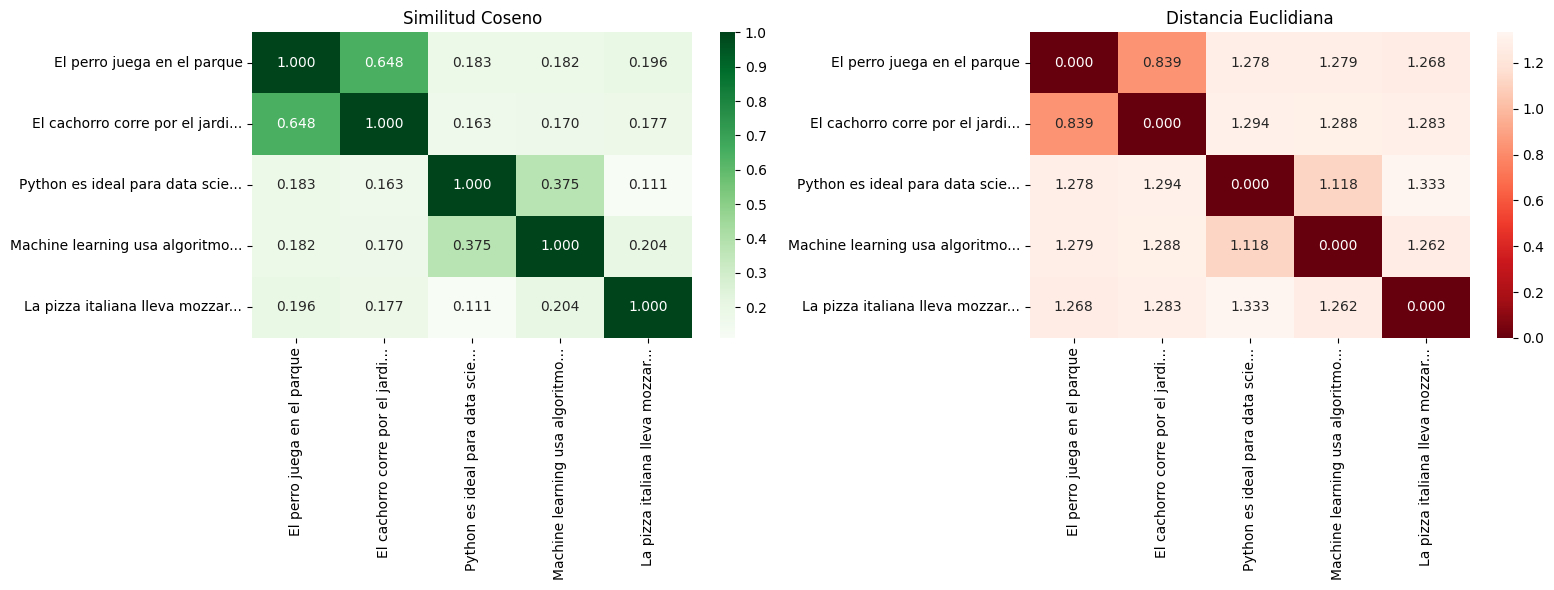

In [13]:
# Corpus mas rico para el heatmap
frases = [
    "El perro juega en el parque",
    "El cachorro corre por el jardin",
    "Python es ideal para data science",
    "Machine learning usa algoritmos estadisticos",
    "La pizza italiana lleva mozzarella",
]

resp = client.embeddings.create(input=frases, model="text-embedding-3-small")
embs = np.array([e.embedding for e in resp.data])

sim_matrix = cosine_similarity(embs)
dist_matrix = euclidean_distances(embs)

# Etiquetas cortas
etiquetas = [f[:30] + "..." if len(f) > 30 else f for f in frases]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(sim_matrix, annot=True, fmt='.3f', cmap='Greens',
            xticklabels=etiquetas, yticklabels=etiquetas, ax=axes[0])
axes[0].set_title('Similitud Coseno')

sns.heatmap(dist_matrix, annot=True, fmt='.3f', cmap='Reds_r',
            xticklabels=etiquetas, yticklabels=etiquetas, ax=axes[1])
axes[1].set_title('Distancia Euclidiana')

plt.tight_layout()
plt.show()

> **Observa:** Las frases sobre animales tienen alta similitud entre si, las de tecnologia entre si, y la de comida es diferente a ambos grupos.

---
## Seccion 4: Busqueda Manual (sin base de datos)

Antes de usar ChromaDB, implementemos una busqueda vectorial "a mano" para entender que hacen las bases de datos vectoriales internamente.

In [14]:
corpus = [
    "Python es un lenguaje de programacion versatil",
    "JavaScript se usa para desarrollo web frontend",
    "Las redes neuronales aprenden de los datos",
    "Docker permite empaquetar aplicaciones en contenedores",
    "SQL es el lenguaje estandar para bases de datos relacionales",
    "React es una libreria de JavaScript para interfaces",
    "Los transformers revolucionaron el NLP",
    "Kubernetes orquesta contenedores en produccion",
    "PostgreSQL es una base de datos relacional robusta",
    "GPT-4 es un modelo de lenguaje grande",
]

# Generar embeddings para todo el corpus
resp = client.embeddings.create(input=corpus, model="text-embedding-3-small")
corpus_embeddings = np.array([e.embedding for e in resp.data])

print(f"Corpus indexado: {corpus_embeddings.shape[0]} documentos, {corpus_embeddings.shape[1]} dimensiones")

Corpus indexado: 10 documentos, 1536 dimensiones


In [15]:
def busqueda_manual(query, corpus_texts, corpus_embs, client, k=3):
    """Busqueda vectorial brute-force con numpy."""
    # Embedding de la query
    resp = client.embeddings.create(input=[query], model="text-embedding-3-small")
    query_emb = np.array(resp.data[0].embedding)

    # Calcular similitud con todo el corpus
    similarities = cosine_similarity([query_emb], corpus_embs)[0]

    # Ordenar por similitud descendente
    top_indices = np.argsort(similarities)[::-1][:k]

    resultados = []
    for idx in top_indices:
        resultados.append({
            'documento': corpus_texts[idx],
            'similitud': similarities[idx],
        })
    return resultados


# Probar busqueda
query = "como crear una pagina web"
resultados = busqueda_manual(query, corpus, corpus_embeddings, client, k=3)

print(f"Query: '{query}'")
print("=" * 60)
for i, r in enumerate(resultados, 1):
    print(f"  {i}. [{r['similitud']:.4f}] {r['documento']}")

Query: 'como crear una pagina web'
  1. [0.3616] JavaScript se usa para desarrollo web frontend
  2. [0.2489] React es una libreria de JavaScript para interfaces
  3. [0.2443] Docker permite empaquetar aplicaciones en contenedores


In [16]:
# Medir tiempos de busqueda manual
queries = [
    "inteligencia artificial",
    "bases de datos",
    "contenedores y despliegue",
    "lenguajes de programacion",
    "deep learning",
]

tiempos = []
for q in queries:
    start = time.perf_counter()
    busqueda_manual(q, corpus, corpus_embeddings, client, k=3)
    elapsed = time.perf_counter() - start
    tiempos.append(elapsed)

print(f"Tiempo promedio por busqueda: {np.mean(tiempos)*1000:.1f} ms")
print(f"\nCon 10 documentos funciona rapido, pero imagina con 1,000,000...")
print(f"Por eso necesitamos indices optimizados como los que ofrecen las bases de datos vectoriales.")

Tiempo promedio por busqueda: 253.4 ms

Con 10 documentos funciona rapido, pero imagina con 1,000,000...
Por eso necesitamos indices optimizados como los que ofrecen las bases de datos vectoriales.


---
## Seccion 5: ChromaDB - Tu Primera Base de Datos Vectorial

**ChromaDB** es una base de datos vectorial open-source, facil de usar y perfecta para prototipos y desarrollo local.

Conceptos clave:
- **Coleccion**: equivalente a una "tabla" en SQL
- **Documento**: texto que se almacena
- **Embedding**: vector generado automaticamente o proporcionado
- **Metadata**: informacion adicional para filtrar

### 5.1 ChromaDB nativo

In [17]:
# Crear cliente en memoria
chroma_client = chromadb.Client()

# Crear coleccion
collection = chroma_client.create_collection(name="mi_primera_coleccion")

# Agregar documentos con metadata
documentos = [
    "Python es un lenguaje de programacion versatil",
    "JavaScript se usa para desarrollo web frontend",
    "Las redes neuronales aprenden de los datos",
    "Docker permite empaquetar aplicaciones en contenedores",
    "SQL es el lenguaje estandar para bases de datos relacionales",
    "React es una libreria de JavaScript para interfaces",
    "Los transformers revolucionaron el NLP",
    "Kubernetes orquesta contenedores en produccion",
    "PostgreSQL es una base de datos relacional robusta",
    "GPT-4 es un modelo de lenguaje grande",
]

categorias = [
    "lenguajes", "lenguajes", "ml", "devops", "datos",
    "lenguajes", "ml", "devops", "datos", "ml",
]

collection.add(
    documents=documentos,
    metadatas=[{"categoria": c} for c in categorias],
    ids=[f"doc_{i}" for i in range(len(documentos))],
)

print(f"Documentos en la coleccion: {collection.count()}")

Documentos en la coleccion: 10


In [18]:
# Busqueda semantica
resultados = collection.query(
    query_texts=["inteligencia artificial y modelos de lenguaje"],
    n_results=3,
)

print("Query: 'inteligencia artificial y modelos de lenguaje'")
print("=" * 60)
for doc, meta, dist in zip(
    resultados['documents'][0],
    resultados['metadatas'][0],
    resultados['distances'][0],
):
    print(f"  [{dist:.4f}] [{meta['categoria']}] {doc}")

Query: 'inteligencia artificial y modelos de lenguaje'
  [1.0212] [ml] GPT-4 es un modelo de lenguaje grande
  [1.2547] [lenguajes] Python es un lenguaje de programacion versatil
  [1.3583] [ml] Las redes neuronales aprenden de los datos


### 5.2 Filtrado por metadata

In [19]:
# Buscar solo en documentos de categoria "ml"
resultados_filtrados = collection.query(
    query_texts=["como funcionan los modelos de IA"],
    n_results=3,
    where={"categoria": "ml"},
)

print("Query: 'como funcionan los modelos de IA' (filtro: categoria=ml)")
print("=" * 60)
for doc, meta, dist in zip(
    resultados_filtrados['documents'][0],
    resultados_filtrados['metadatas'][0],
    resultados_filtrados['distances'][0],
):
    print(f"  [{dist:.4f}] [{meta['categoria']}] {doc}")

Query: 'como funcionan los modelos de IA' (filtro: categoria=ml)
  [1.1083] [ml] GPT-4 es un modelo de lenguaje grande
  [1.3377] [ml] Los transformers revolucionaron el NLP
  [1.4556] [ml] Las redes neuronales aprenden de los datos


In [20]:
# Buscar en documentos de categoria "lenguajes" o "datos"
resultados_multi = collection.query(
    query_texts=["herramientas para trabajar con informacion"],
    n_results=5,
    where={"$or": [{"categoria": "lenguajes"}, {"categoria": "datos"}]},
)

print("Query: 'herramientas para trabajar con informacion'")
print("Filtro: categoria IN ['lenguajes', 'datos']")
print("=" * 60)
for doc, meta, dist in zip(
    resultados_multi['documents'][0],
    resultados_multi['metadatas'][0],
    resultados_multi['distances'][0],
):
    print(f"  [{dist:.4f}] [{meta['categoria']}] {doc}")

Query: 'herramientas para trabajar con informacion'
Filtro: categoria IN ['lenguajes', 'datos']
  [1.3350] [datos] SQL es el lenguaje estandar para bases de datos relacionales
  [1.5137] [datos] PostgreSQL es una base de datos relacional robusta
  [1.6261] [lenguajes] JavaScript se usa para desarrollo web frontend
  [1.6581] [lenguajes] React es una libreria de JavaScript para interfaces
  [1.6858] [lenguajes] Python es un lenguaje de programacion versatil


### 5.3 ChromaDB con LangChain

In [21]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Crear vectorstore con LangChain
vectorstore = Chroma.from_texts(
    texts=documentos,
    embedding=embeddings,
    metadatas=[{"categoria": c} for c in categorias],
)

# Usar como retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

docs = retriever.invoke("como desplegar aplicaciones")

print("Query: 'como desplegar aplicaciones'")
print("=" * 60)
for i, doc in enumerate(docs, 1):
    print(f"  {i}. [{doc.metadata.get('categoria', 'N/A')}] {doc.page_content}")

Query: 'como desplegar aplicaciones'
  1. [devops] Docker permite empaquetar aplicaciones en contenedores
  2. [devops] Kubernetes orquesta contenedores en produccion
  3. [lenguajes] JavaScript se usa para desarrollo web frontend


---
## Seccion 6: Visualizacion de Embeddings

Los embeddings tienen muchas dimensiones (384 o 1536). Para visualizarlos usamos tecnicas de **reduccion de dimensionalidad**:

- **PCA** (Principal Component Analysis): proyeccion lineal rapida
- **t-SNE**: proyeccion no lineal que preserva vecindarios locales

In [22]:
# Generar embeddings para el corpus completo + query
query_text = "como funciona la inteligencia artificial"

all_texts = corpus + [query_text]
resp = client.embeddings.create(input=all_texts, model="text-embedding-3-small")
all_embeddings = np.array([e.embedding for e in resp.data])

# Separar corpus y query
corpus_embs_viz = all_embeddings[:-1]
query_emb_viz = all_embeddings[-1:]

# Calcular distancias de la query a cada documento
similarities_viz = cosine_similarity(query_emb_viz, corpus_embs_viz)[0]
top_k = 3
top_indices_viz = np.argsort(similarities_viz)[::-1][:top_k]

print(f"Top {top_k} documentos mas similares a '{query_text}':")
for idx in top_indices_viz:
    print(f"  [{similarities_viz[idx]:.4f}] {corpus[idx]}")

Top 3 documentos mas similares a 'como funciona la inteligencia artificial':
  [0.4516] Los transformers revolucionaron el NLP
  [0.4145] Las redes neuronales aprenden de los datos
  [0.3215] GPT-4 es un modelo de lenguaje grande


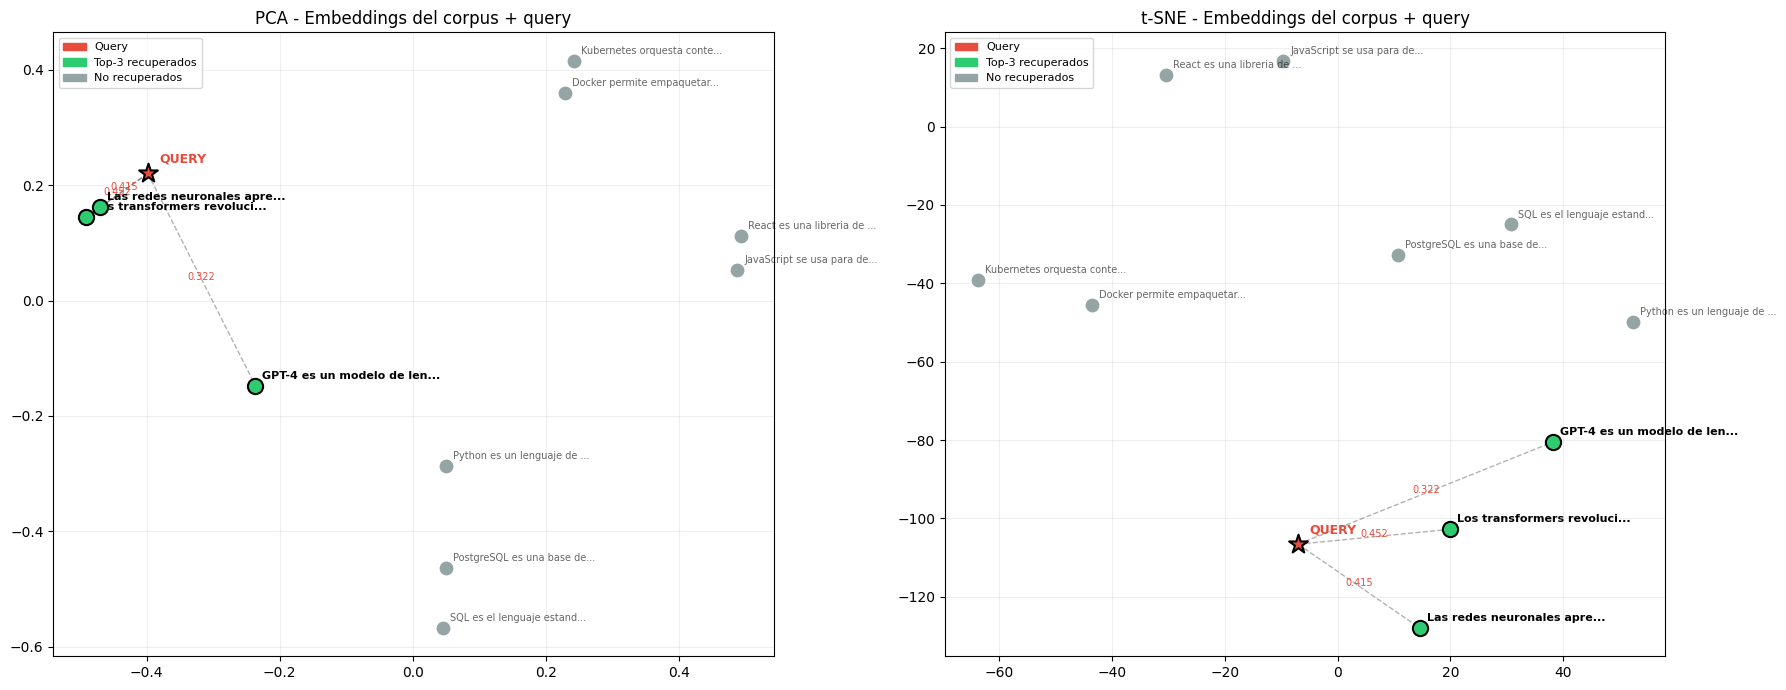

In [23]:
# PCA vs t-SNE lado a lado
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings)

perplexity = min(5, len(all_texts) - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, result, title in zip(axes, [pca_result, tsne_result], ['PCA', 't-SNE']):
    # Documentos no recuperados (gris)
    for i in range(len(corpus)):
        if i not in top_indices_viz:
            ax.scatter(result[i, 0], result[i, 1], c='#95a5a6', s=80, zorder=2)
            ax.annotate(corpus[i][:25] + '...', (result[i, 0], result[i, 1]),
                       fontsize=7, alpha=0.6, xytext=(5, 5),
                       textcoords='offset points')

    # Documentos recuperados (verde)
    for idx in top_indices_viz:
        ax.scatter(result[idx, 0], result[idx, 1], c='#2ecc71', s=120,
                  edgecolors='black', linewidth=1.5, zorder=3)
        ax.annotate(corpus[idx][:25] + '...', (result[idx, 0], result[idx, 1]),
                   fontsize=8, fontweight='bold', xytext=(5, 5),
                   textcoords='offset points')
        # Linea desde query al documento recuperado
        ax.plot([result[-1, 0], result[idx, 0]],
                [result[-1, 1], result[idx, 1]],
                'k--', alpha=0.3, linewidth=1)
        mid_x = (result[-1, 0] + result[idx, 0]) / 2
        mid_y = (result[-1, 1] + result[idx, 1]) / 2
        ax.annotate(f"{similarities_viz[idx]:.3f}", (mid_x, mid_y),
                   fontsize=7, color='#e74c3c', ha='center')

    # Query (rojo)
    ax.scatter(result[-1, 0], result[-1, 1], c='#e74c3c', s=200,
              marker='*', edgecolors='black', linewidth=1.5, zorder=4)
    ax.annotate('QUERY', (result[-1, 0], result[-1, 1]),
               fontsize=9, fontweight='bold', color='#e74c3c',
               xytext=(8, 8), textcoords='offset points')

    ax.set_title(f'{title} - Embeddings del corpus + query', fontsize=12)
    ax.grid(True, alpha=0.2)

    legend_elements = [
        mpatches.Patch(color='#e74c3c', label='Query'),
        mpatches.Patch(color='#2ecc71', label=f'Top-{top_k} recuperados'),
        mpatches.Patch(color='#95a5a6', label='No recuperados'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

---
## Seccion 7: Filtrado por Metadata y Busqueda Hibrida

En aplicaciones reales, la busqueda puramente semantica no siempre basta. Combinamos:

- **Busqueda semantica**: encontrar documentos por significado
- **Filtrado por metadata**: restringir por atributos (categoria, fecha, autor)
- **Busqueda por keyword**: coincidencia exacta de palabras

In [24]:
# Crear coleccion con metadata mas rica
chroma_client2 = chromadb.Client()
col_rich = chroma_client2.create_collection(name="docs_metadata_rica")

docs_ricos = [
    {"text": "Python 3.12 introduce mejoras en el rendimiento del interprete",
     "categoria": "lenguajes", "anio": 2024, "nivel": "intermedio"},
    {"text": "FastAPI es un framework web moderno y rapido para Python",
     "categoria": "frameworks", "anio": 2023, "nivel": "intermedio"},
    {"text": "TensorFlow 2.x simplifica la creacion de redes neuronales",
     "categoria": "ml", "anio": 2023, "nivel": "avanzado"},
    {"text": "Docker Compose permite definir aplicaciones multi-contenedor",
     "categoria": "devops", "anio": 2024, "nivel": "intermedio"},
    {"text": "Introduccion a variables y tipos de datos en Python",
     "categoria": "lenguajes", "anio": 2024, "nivel": "basico"},
    {"text": "Redes neuronales convolucionales para vision por computadora",
     "categoria": "ml", "anio": 2024, "nivel": "avanzado"},
    {"text": "Git y GitHub para control de versiones colaborativo",
     "categoria": "devops", "anio": 2023, "nivel": "basico"},
    {"text": "LangChain permite crear aplicaciones con LLMs",
     "categoria": "ml", "anio": 2024, "nivel": "avanzado"},
]

col_rich.add(
    documents=[d["text"] for d in docs_ricos],
    metadatas=[{k: v for k, v in d.items() if k != "text"} for d in docs_ricos],
    ids=[f"doc_{i}" for i in range(len(docs_ricos))],
)

print(f"Coleccion creada con {col_rich.count()} documentos")

Coleccion creada con 8 documentos


In [25]:
# Comparacion: semantica pura vs filtrada
query_hibrida = "aprender inteligencia artificial"

# 1. Semantica pura
r_semantica = col_rich.query(query_texts=[query_hibrida], n_results=3)

# 2. Filtrada: solo documentos de 2024 y nivel avanzado
r_filtrada = col_rich.query(
    query_texts=[query_hibrida],
    n_results=3,
    where={"$and": [{"anio": {"$gte": 2024}}, {"nivel": "avanzado"}]},
)

# 3. Solo basicos
r_basica = col_rich.query(
    query_texts=[query_hibrida],
    n_results=3,
    where={"nivel": "basico"},
)

print(f"Query: '{query_hibrida}'")
print("\n" + "=" * 60)
print("SEMANTICA PURA (sin filtros):")
print("-" * 50)
for doc, meta in zip(r_semantica['documents'][0], r_semantica['metadatas'][0]):
    print(f"  [{meta['categoria']}|{meta['anio']}|{meta['nivel']}] {doc}")

print("\n" + "=" * 60)
print("FILTRADA (anio >= 2024 AND nivel = avanzado):")
print("-" * 50)
for doc, meta in zip(r_filtrada['documents'][0], r_filtrada['metadatas'][0]):
    print(f"  [{meta['categoria']}|{meta['anio']}|{meta['nivel']}] {doc}")

print("\n" + "=" * 60)
print("FILTRADA (nivel = basico):")
print("-" * 50)
for doc, meta in zip(r_basica['documents'][0], r_basica['metadatas'][0]):
    print(f"  [{meta['categoria']}|{meta['anio']}|{meta['nivel']}] {doc}")

Query: 'aprender inteligencia artificial'

SEMANTICA PURA (sin filtros):
--------------------------------------------------
  [ml|2024|avanzado] Redes neuronales convolucionales para vision por computadora
  [lenguajes|2024|intermedio] Python 3.12 introduce mejoras en el rendimiento del interprete
  [ml|2023|avanzado] TensorFlow 2.x simplifica la creacion de redes neuronales

FILTRADA (anio >= 2024 AND nivel = avanzado):
--------------------------------------------------
  [ml|2024|avanzado] Redes neuronales convolucionales para vision por computadora
  [ml|2024|avanzado] LangChain permite crear aplicaciones con LLMs

FILTRADA (nivel = basico):
--------------------------------------------------
  [lenguajes|2024|basico] Introduccion a variables y tipos de datos en Python
  [devops|2023|basico] Git y GitHub para control de versiones colaborativo


---
## Resumen

En esta notebook aprendimos:

| Concepto | Descripcion |
|----------|-------------|
| Vector | Lista ordenada de numeros que representa datos |
| Embedding | Vector que captura el significado semantico del texto |
| Similitud coseno | Metrica que mide el angulo entre vectores (1=identico, 0=diferente) |
| Distancia euclidiana | Distancia recta entre dos puntos en el espacio |
| ChromaDB | Base de datos vectorial open-source para busqueda semantica |
| Metadata filtering | Restringir busqueda por atributos estructurados |
| PCA / t-SNE | Tecnicas para visualizar embeddings de alta dimension en 2D |

### Checklist de consolidacion

- [ ] Puedo explicar la diferencia entre un vector y un embedding
- [ ] Se calcular similitud coseno manualmente
- [ ] Entiendo cuando usar coseno vs distancia euclidiana
- [ ] Puedo crear una coleccion en ChromaDB y hacer queries
- [ ] Se usar filtros de metadata para refinar busquedas
- [ ] Comprendo la diferencia entre PCA y t-SNE para visualizacion